In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [2]:
# load data from csv
try:
    file_path = os.path.join(os.getcwd(), '../data/data.csv')
    df = pd.read_csv(file_path)
except Exception as e:
    df = pd.DataFrame()
    print(e)

print(df)

           mode        b1      b2      b3       r1              r2      r3  y
0      knockout    BARLEY   PIPER    RICO     GENE  LARRY & LAWRIE    TICK  1
1        bounty     BELLE    CARL    GENE     GRAY            NANI     R-T  1
2       hotZone       BEA  JESSIE     STU    AMBER          BARLEY    NITA  1
3       gemGrab  DYNAMIKE    FANG   PEARL  CHESTER            GENE  MORTIS  1
4     brawlBall      BUZZ  CLANCY    NITA   BUSTER           BYRON   SANDY  0
...         ...       ...     ...     ...      ...             ...     ... ..
5509    gemGrab      CARL  JESSIE     MEG  CHESTER            GALE    LEON  1
5510      heist      CARL    CROW   PIPER    BROCK            GALE  JESSIE  1
5511    gemGrab    BUSTER     MEG  MORTIS  COLETTE            LEON    RICO  1
5512     bounty       LOU   PIPER  SPROUT    BYRON            FANG   MANDY  0
5513    hotZone    BUSTER    LILY    NITA   CLANCY  LARRY & LAWRIE   SURGE  0

[5514 rows x 8 columns]


In [3]:
# look at unique brawler names
names = pd.unique(df[['b1', 'b2', 'b3', 'r1', 'r2', 'r3']].values.ravel())
names.sort()

# print(len(names))
print(names)

# save brawler names
pd.Series(names).to_csv(os.path.join(os.getcwd(), '../models/names.csv'), index=False, header=False)

# look at unique game modes
modes = pd.unique(df[['mode']].values.ravel())
modes.sort()

# print(len(modes))
print(modes)

# save game modes
pd.Series(modes).to_csv(os.path.join(os.getcwd(), '../models/modes.csv'), index=False, header=False)

['8-BIT' 'AMBER' 'ANGELO' 'ASH' 'BARLEY' 'BEA' 'BELLE' 'BERRY' 'BIBI' 'BO'
 'BONNIE' 'BROCK' 'BULL' 'BUSTER' 'BUZZ' 'BYRON' 'CARL' 'CHARLIE'
 'CHESTER' 'CHUCK' 'CLANCY' 'COLETTE' 'COLT' 'CORDELIUS' 'CROW' 'DARRYL'
 'DOUG' 'DRACO' 'DYNAMIKE' 'EDGAR' 'EL PRIMO' 'EMZ' 'EVE' 'FANG' 'FRANK'
 'GALE' 'GENE' 'GRAY' 'GRIFF' 'GROM' 'GUS' 'HANK' 'JACKY' 'JANET' 'JESSIE'
 'KIT' 'LARRY & LAWRIE' 'LEON' 'LILY' 'LOLA' 'LOU' 'MAISIE' 'MANDY' 'MAX'
 'MEG' 'MELODIE' 'MICO' 'MORTIS' 'MR. P' 'NANI' 'NITA' 'OTIS' 'PAM'
 'PEARL' 'PENNY' 'PIPER' 'POCO' 'R-T' 'RICO' 'ROSA' 'RUFFS' 'SAM' 'SANDY'
 'SHELLY' 'SPIKE' 'SPROUT' 'SQUEAK' 'STU' 'SURGE' 'TARA' 'TICK' 'WILLOW']
['bounty' 'brawlBall' 'gemGrab' 'heist' 'hotZone' 'knockout']


In [4]:
# one-hot encode modes and brawlers
encoder = OneHotEncoder(
    categories=[
        modes,
        names,
        names,
        names,
        names, 
        names,
        names,], drop=None, handle_unknown='ignore', sparse_output=False)

X = df[['mode', 'b1','b2','b3','r1','r2','r3']]
X = encoder.fit_transform(X)
y = df['y'].values

# save one-hot encoder
dump(encoder, os.path.join(os.getcwd(), '../models/encoder.joblib'))

# split train-test 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(4411, 498) (1103, 498)
(4411,) (1103,)


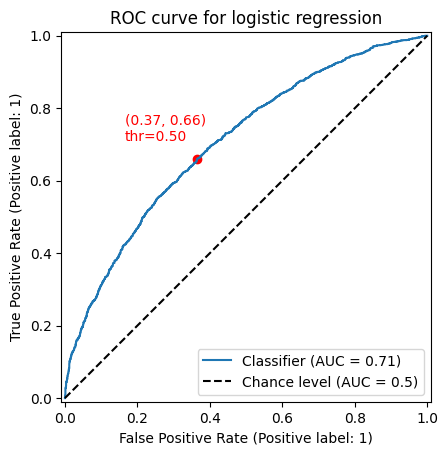

In [5]:
# first try: logistic regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# save model
dump(lr_model, os.path.join(os.getcwd(), '../models/lr.joblib'))

# find operating point
y_proba = lr_model.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_proba)
dist = np.square(fpr) + np.square(1-tpr)
op_idx = np.argmin(dist)
lr_op_pnt = thresholds[op_idx]

# plot roc curve
RocCurveDisplay.from_predictions(y_train, y_proba, plot_chance_level=True)
plt.scatter(fpr[op_idx], tpr[op_idx], color='red')
plt.text(fpr[op_idx] - 0.2, tpr[op_idx] + 0.05,
         f"({fpr[op_idx]:.2f}, {tpr[op_idx]:.2f})\nthr={thresholds[op_idx]:.2f}",
         color='red', fontsize=10)
plt.title("ROC curve for logistic regression")
plt.show()
plt.close()

In [6]:
# report training performance
y_hat_train = (lr_model.predict_proba(X_train)[:, 1] > lr_op_pnt)

print("Training performance:")
print(classification_report(y_train, y_hat_train))

# report testing performance
y_hat_test = (lr_model.predict_proba(X_test)[:, 1] > lr_op_pnt)

print("Testing performance:")
print(classification_report(y_test, y_hat_test))

Training performance:
              precision    recall  f1-score   support

           0       0.64      0.63      0.64      2165
           1       0.65      0.66      0.66      2246

    accuracy                           0.65      4411
   macro avg       0.65      0.65      0.65      4411
weighted avg       0.65      0.65      0.65      4411

Testing performance:
              precision    recall  f1-score   support

           0       0.56      0.51      0.53       576
           1       0.51      0.57      0.54       527

    accuracy                           0.53      1103
   macro avg       0.54      0.54      0.53      1103
weighted avg       0.54      0.53      0.53      1103



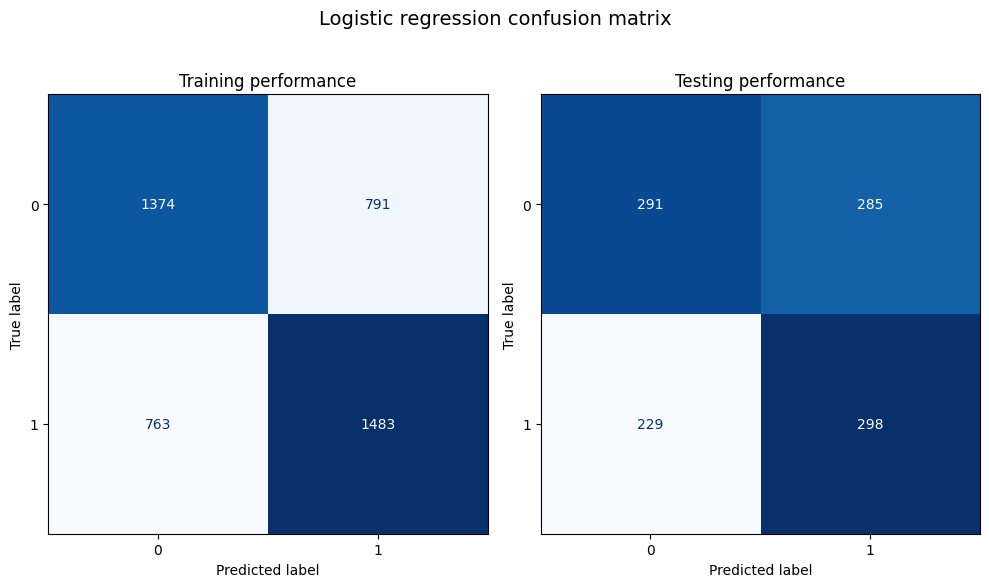

In [7]:
# plot confusion matrices
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test  = confusion_matrix(y_test, y_hat_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

titles = ["Training performance", "Testing performance"]
cms = [cm_train, cm_test]
data = [(y_train, y_hat_train), (y_test, y_hat_test)]

for ax, cm, title in zip(axes, cms, titles):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(title)

plt.suptitle("Logistic regression confusion matrix", fontsize=14)
plt.savefig(os.path.join(os.getcwd(), "../output/lr_training_testing_confusion_matrices.png"))
plt.tight_layout()
plt.show()
plt.close()

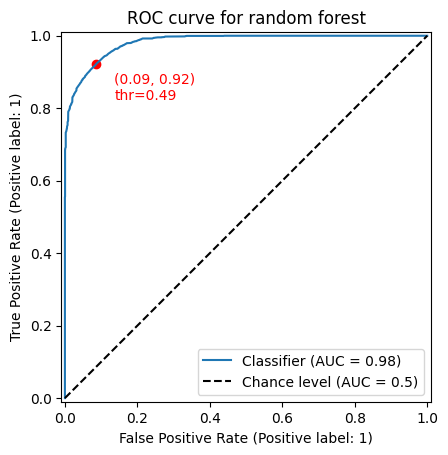

In [8]:
# second try: random forest
rf_model = RandomForestClassifier(n_estimators=20, random_state=42)
rf_model.fit(X_train, y_train)

# save model
dump(rf_model, os.path.join(os.getcwd(), '../models/rf.joblib'))

# find operating point
y_proba = rf_model.predict_proba(X_train)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_proba)
dist = np.square(fpr) + np.square(1-tpr)
op_idx = np.argmin(dist)
rf_op_pnt = thresholds[op_idx]

# plot roc curve
RocCurveDisplay.from_predictions(y_train, y_proba, plot_chance_level=True)
plt.scatter(fpr[op_idx], tpr[op_idx], color='red')
plt.text(fpr[op_idx] + 0.05, tpr[op_idx] - 0.1,
         f"({fpr[op_idx]:.2f}, {tpr[op_idx]:.2f})\nthr={thresholds[op_idx]:.2f}",
         color='red', fontsize=10)
plt.title("ROC curve for random forest")
plt.show()
plt.close()

In [9]:
# report training performance
y_hat_train = (rf_model.predict_proba(X_train)[:, 1] > rf_op_pnt)

print("Training performance:")
print(classification_report(y_train, y_hat_train))

# report testing performance
y_hat_test = (rf_model.predict_proba(X_test)[:, 1] > rf_op_pnt)

print("Testing performance:")
print(classification_report(y_test, y_hat_test))

Training performance:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2165
           1       0.92      0.92      0.92      2246

    accuracy                           0.92      4411
   macro avg       0.92      0.92      0.92      4411
weighted avg       0.92      0.92      0.92      4411

Testing performance:
              precision    recall  f1-score   support

           0       0.64      0.57      0.60       576
           1       0.58      0.65      0.61       527

    accuracy                           0.61      1103
   macro avg       0.61      0.61      0.61      1103
weighted avg       0.61      0.61      0.61      1103



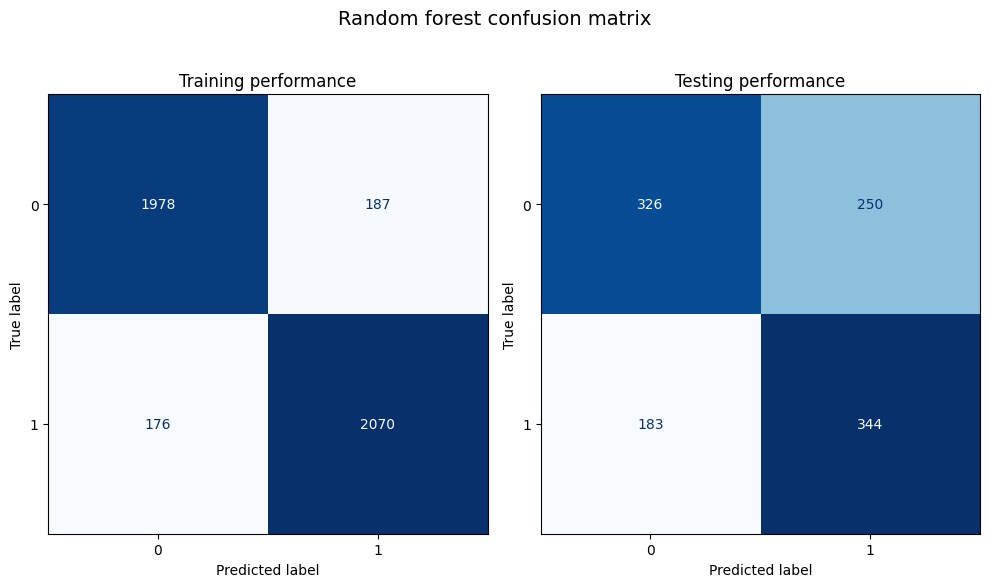

In [10]:
# plot confusion matrices
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test  = confusion_matrix(y_test, y_hat_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

titles = ["Training performance", "Testing performance"]
cms = [cm_train, cm_test]
data = [(y_train, y_hat_train), (y_test, y_hat_test)]

for ax, cm, title in zip(axes, cms, titles):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(title)

plt.suptitle("Random forest confusion matrix", fontsize=14)
plt.savefig(os.path.join(os.getcwd(), "../output/rf_training_testing_confusion_matrices.png"))
plt.tight_layout()
plt.show()
plt.close()

In [11]:
# convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([4411, 498]) torch.Size([1103, 498])
torch.Size([4411, 1]) torch.Size([1103, 1])


In [ ]:
# define neural network architecture
class Net(nn.Module):
    # two hidden layers of 32 neurons, ReLU activations, sigmoid output
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, 32), nn.ReLU(), nn.Linear(32, 1), nn.Sigmoid())
    
    def forward(self, x):
        return self.net(x)

100%|██████████| 512/512 [00:04<00:00, 117.45it/s]


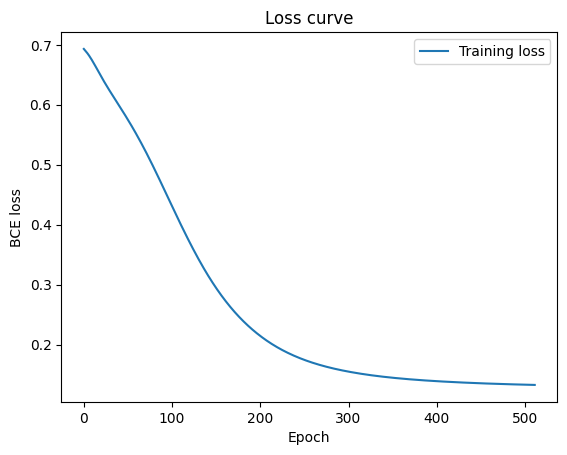

In [13]:
# third try: neural network
torch.manual_seed(42)

# create neural network
nn_model = Net(X_train.shape[1])
optimizer = torch.optim.Adam(nn_model.parameters(), lr=3e-3)
loss_fn = nn.BCELoss()

# track training loss
training_loss = []

# train model
num_epochs = 512

for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    y_pred = nn_model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()

    epoch_loss = loss.item()
    training_loss.append(epoch_loss)

# save model
torch.save(nn_model, os.path.join(os.getcwd(), '../models/nn.pth'))

# plot training loss
plt.figure()
plt.plot(range(num_epochs), training_loss)
# plt.plot(range(0, num_epochs, 50), testing_acc)
plt.title("Loss curve")
plt.legend(['Training loss'])
plt.xlabel("Epoch")
plt.ylabel("BCE loss")
plt.savefig(os.path.join(os.getcwd(), "../output/nn_loss_curve.png"))
plt.show()
plt.close()

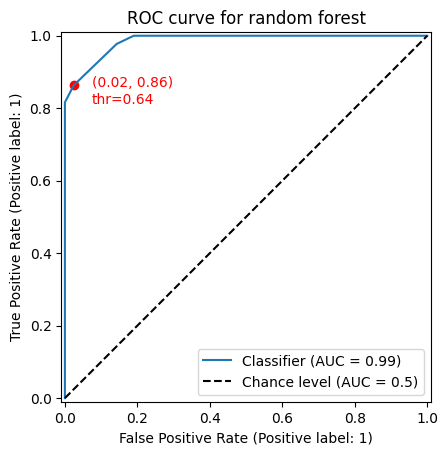

In [14]:
# find operating point
with torch.no_grad():
    y_proba = nn_model(X_train).numpy()

fpr, tpr, thresholds = roc_curve(y_train, y_proba)
dist = np.square(fpr) + np.square(1-tpr)
op_idx = np.argmin(dist)
nn_op_pnt = thresholds[op_idx]

# plot roc curve
RocCurveDisplay.from_predictions(y_train, y_proba, plot_chance_level=True)
plt.scatter(fpr[op_idx], tpr[op_idx], color='red')
plt.text(fpr[op_idx] + 0.05, tpr[op_idx] - 0.05,
         f"({fpr[op_idx]:.2f}, {tpr[op_idx]:.2f})\nthr={thresholds[op_idx]:.2f}",
         color='red', fontsize=10)
plt.title("ROC curve for random forest")
plt.show()
plt.close()

In [15]:
# report training performance
with torch.no_grad():
    y_proba = nn_model(X_train).numpy()

y_hat_train = (y_proba > nn_op_pnt).astype(int)

print("Training performance:")
print(classification_report(y_train, y_hat_train))

# report testing performance
with torch.no_grad():
    y_proba = nn_model(X_test).numpy()

y_hat_test = (y_proba > nn_op_pnt).astype(int)

print("Testing performance:")
print(classification_report(y_test, y_hat_test))

Training performance:
              precision    recall  f1-score   support

         0.0       0.87      0.98      0.92      2165
         1.0       0.97      0.86      0.91      2246

    accuracy                           0.92      4411
   macro avg       0.92      0.92      0.92      4411
weighted avg       0.92      0.92      0.92      4411

Testing performance:
              precision    recall  f1-score   support

         0.0       0.63      0.62      0.63       576
         1.0       0.59      0.61      0.60       527

    accuracy                           0.61      1103
   macro avg       0.61      0.61      0.61      1103
weighted avg       0.61      0.61      0.61      1103



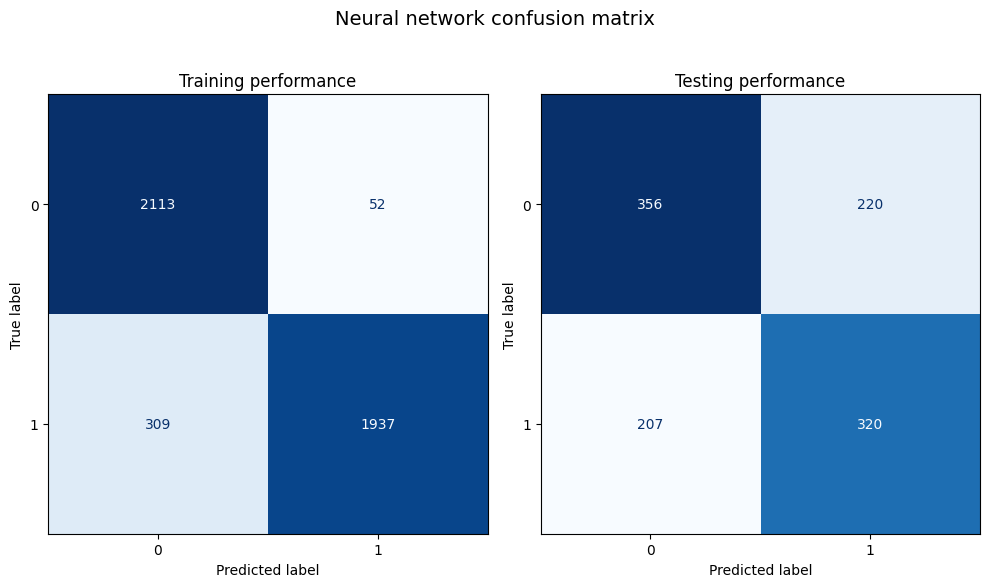

In [16]:
# plot confusion matrices
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test  = confusion_matrix(y_test, y_hat_test)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

titles = ["Training performance", "Testing performance"]
cms = [cm_train, cm_test]
data = [(y_train, y_hat_train), (y_test, y_hat_test)]

for ax, cm, title in zip(axes, cms, titles):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(title)

plt.suptitle("Neural network confusion matrix", fontsize=14)
plt.savefig(os.path.join(os.getcwd(), "../output/nn_training_testing_confusion_matrices.png"))
plt.tight_layout()
plt.show()
plt.close()

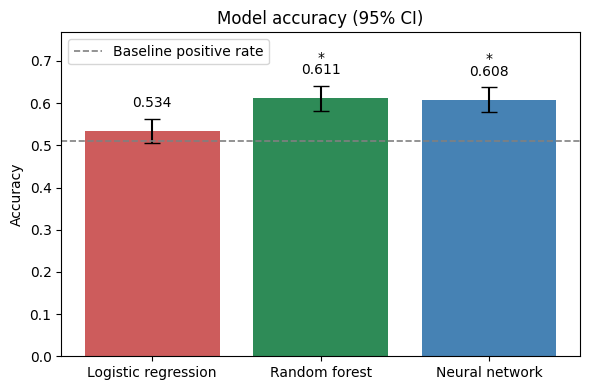

In [ ]:
# switch to numpy
y_train = y_train.detach().numpy().flatten()
y_test = y_test.detach().numpy().flatten()

# evaluate logistic regression
y_pred_lr = (lr_model.predict_proba(X_test)[:, 1] > 0.5).astype(int)
acc_lr = accuracy_score(y_test, y_pred_lr)

# evaluate random forest
y_pred_rf = (rf_model.predict_proba(X_test)[:, 1] > 0.5).astype(int)
acc_rf = accuracy_score(y_test, y_pred_rf)

# evaluate neural network
with torch.no_grad():
    y_proba_nn = nn_model(X_test).numpy().flatten()
    y_pred_nn = (y_proba_nn > 0.5).astype(int)
acc_nn = accuracy_score(y_test.flatten(), y_pred_nn)

# compute 95% confidence intervals
alpha = 0.05
z = 1.96

accs = np.array([acc_lr, acc_rf, acc_nn])
cis = z * np.sqrt((accs * (1 - accs)) / len(y_test))

# compute baseline positive rate
p_majority = np.mean(y_train)
acc_chance = max(p_majority, 1-p_majority)

# plot accuracy bars
models = ['Logistic regression', 'Random forest', 'Neural network']

plt.figure(figsize=(6, 4))
bars = plt.bar(models, accs, yerr=cis, capsize=6, color=['indianred', 'seagreen', 'steelblue'])

# plot baseline positive rate
plt.axhline(acc_chance, color='gray', linestyle='--', linewidth=1.2, label='Baseline positive rate')

for bar, val in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.05,
             f"{val:.3f}", ha='center', va='bottom')

plt.ylabel("Accuracy")
plt.title("Model accuracy (95% CI)")
plt.ylim(0, 1.2 * max(accs + cis))
plt.legend()

# mark statisticla significance
for i, (bar, acc, ci) in enumerate(zip(bars, accs, cis)):
    if acc - ci > acc_chance:
        plt.text(bar.get_x() + bar.get_width()/2, acc + ci + 0.05, "*", 
                 ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "../output/acc.png"))
plt.show()

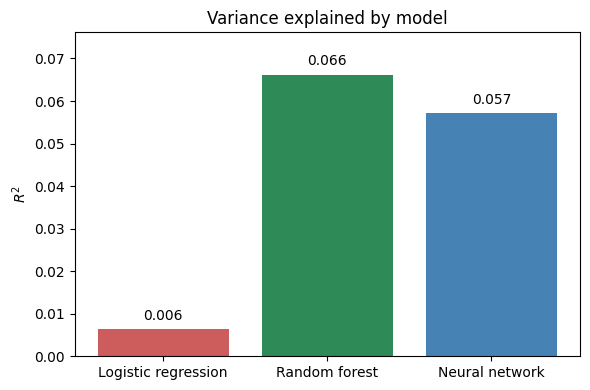

In [ ]:
# compute R^2 coefficients
r2_lr = np.corrcoef(y_test.flatten(), lr_model.predict_proba(X_test)[:, 1].flatten())[0, 1] ** 2
r2_rf = np.corrcoef(y_test.flatten(), rf_model.predict_proba(X_test)[:, 1].flatten())[0, 1] ** 2

with torch.no_grad():
    y_proba = nn_model(X_test).numpy()
    r2_nn = np.corrcoef(y_test.flatten(), y_proba.flatten())[0, 1] ** 2

# plot R^2 coefficients
models = ['Logistic regression', 'Random forest', 'Neural network']
r2_values = [r2_lr, r2_rf, r2_nn]

plt.figure(figsize=(6, 4))
bars = plt.bar(models, r2_values, color=['indianred', 'seagreen', 'steelblue'])

for bar, val in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0015,
             f"{val:.3f}", ha='center', va='bottom')

plt.ylabel("$R^2$")
plt.title("Variance explained by model")
plt.ylim(0, max(r2_values)*1.15)
plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "../output/r2.png"))
plt.show()